# Demo 5: Predicting Gold Futures prices

## Imports

In [1]:
from datetime import datetime, timedelta
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tzlocal import get_localzone_name
import yfinance as yf

2023-04-10 17:16:59.317274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Introduction

Gold futures are contracts that allow investors to purchase or sell gold at a predetermined price on a specific future date. As such, gold futures can be used as a tool for hedging against inflation and currency risks, as well as for speculating on the future price of gold. In the context of predicting a recession, gold futures can provide valuable insights into the state of the economy. Historically, gold prices have tended to rise during times of economic uncertainty and market volatility, as investors flock to safe-haven assets like gold. Therefore, changes in gold futures prices can be used as a leading indicator of economic trends and recessions. By analyzing the relationship between gold futures and other economic indicators, such as GDP growth, inflation, and unemployment, it is possible to build predictive models that can forecast the likelihood of a recession.

In this demo, we will explore the use of different predictive techniques to predict gold futures prices and evaluate the accuracy of our predictions.

Let's try downloading our data from Yahoo Finance API. 

In [2]:
ticker = f"MGC=F"
time_diff = 365 * 2
end_date = datetime.today().strftime("%Y-%m-%d")
start_date = (datetime.today() - timedelta(days=time_diff)).strftime("%Y-%m-%d")
print(start_date)

2021-04-10


In [3]:
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


## Train test split

I am going to split the data into training and test portions. 

In [4]:
test_size = 0.01

In [5]:
n = len(data)

n_test = int(n * test_size // 1)
n_train = n - n_test

In [6]:
train_data, test_data = data[:n_train], data[n_train:]
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-12,1739.599976,1742.199951,1730.300049,1731.199951,1731.199951,20
2021-04-13,1747.199951,1747.199951,1746.199951,1746.199951,1746.199951,18
2021-04-14,1735.800049,1735.800049,1734.900024,1734.900024,1734.900024,1
2021-04-15,1752.599976,1765.400024,1752.599976,1765.400024,1765.400024,7
2021-04-16,1760.000000,1780.000000,1759.599976,1779.000000,1779.000000,27
...,...,...,...,...,...,...
2023-03-24,1996.199951,2006.300049,1977.800049,1983.800049,1983.800049,104386
2023-03-27,1982.000000,1983.400024,1944.699951,1953.800049,1953.800049,68192
2023-03-28,1958.500000,1977.199951,1949.800049,1973.500000,1973.500000,56333


## Exploratory Data Analysis (EDA)

Check if any missing values of the data: 

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499 entries, 2021-04-12 to 2023-03-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       499 non-null    float64
 1   High       499 non-null    float64
 2   Low        499 non-null    float64
 3   Close      499 non-null    float64
 4   Adj Close  499 non-null    float64
 5   Volume     499 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.3 KB


Check columns of the data: 

In [8]:
train_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,1812.589780,1822.223247,1802.583966,1812.509018,1812.509018,24657.865731
std,78.579280,80.130405,76.605094,78.359130,78.359130,30958.183902
min,1619.500000,1627.500000,1613.800049,1623.599976,1623.599976,0.000000
25%,1768.750000,1777.150024,1760.150024,1768.100037,1768.100037,11.000000
50%,1807.000000,1815.199951,1795.900024,1806.000000,1806.000000,3222.000000
75%,1860.049988,1869.000000,1847.700012,1862.100037,1862.100037,46729.500000
max,2058.199951,2078.500000,1985.900024,2043.300049,2043.300049,198968.000000


We will use the `Adj Close` (adjusted close) price as our input data and the price to be predicted. 

## First Visualization of the Data

In [9]:
dates = train_data.index

In [10]:
X_raw = train_data["Adj Close"].values

Let's plot the data and observe patterns: 

In [11]:
train_end_timestamp = train_data.iloc[-1].name
train_end_date = datetime(train_end_timestamp.year, train_end_timestamp.month, train_end_timestamp.day).strftime("%Y-%m-%d")

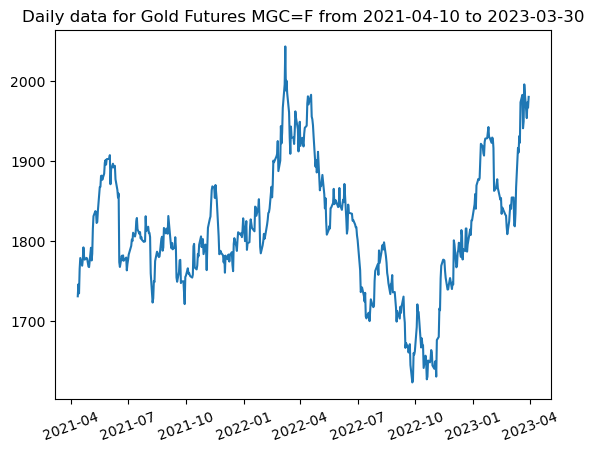

In [12]:
plt.plot(dates, X_raw)
plt.title(f"Daily data for Gold Futures MGC=F from {start_date} to {train_end_date}")
plt.xticks(rotation=20)
plt.show()

## Time-series modelling

Let's try time-series modelling (specifically ARIMA modelling) on this data, similar to the [previous demo](https://github.com/adrianli375/Test-Project/blob/main/demo/demo_4_exchange_rate.ipynb). 

### Autocorrelation

Autocorrelation is a measure of the degree of similarity between a time series and a lagged version of itself. It quantifies the relationship between observations of a time series that are separated by a given time lag, and can be used to identify patterns and dependencies in the data. A time series with high autocorrelation implies that there is a strong relationship between adjacent observations, while a time series with low autocorrelation suggests that there is no significant relationship between adjacent observations.

Let's try to plot the autocorrelation function (acf) of the series: 

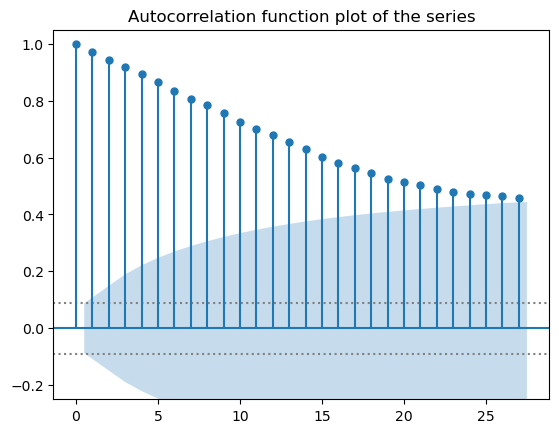

In [13]:
fig, ax = plt.subplots()

n = len(X_raw)
lower_signi_bound = -2 / np.sqrt(n)
upper_signi_bound = 2 / np.sqrt(n)

# Add the horizontal lines showing the significant bounds
ax.axhline(y=lower_signi_bound, linestyle=':', color='gray')
ax.axhline(y=upper_signi_bound, linestyle=':', color='gray')

plot_acf(X_raw, ax=ax)
plt.title("Autocorrelation function plot of the series")
plt.ylim(-0.25, 1.05)

plt.show()

The acf plot suggests that the acf decays slowlt, meaning that fitting an autoregressive (AR) process is plausible. 

### Partial Autocorrelation

Partial autocorrelation refers to the correlation between a time series variable and a lagged version of itself, after removing the linear dependence of this lagged version on all the intermediate lagged versions. In other words, it measures the correlation between a time series and its lagged version, after accounting for the correlation of the time series with all the intermediate lags between them. The partial autocorrelation function (PACF) is a tool used in time series analysis to identify the order of the autoregressive (AR) model, which helps in forecasting future values of the series.

Let's try to plot the pacf of our series obtained: 

/Users/adrianli375/miniconda3/envs/cpsc330/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


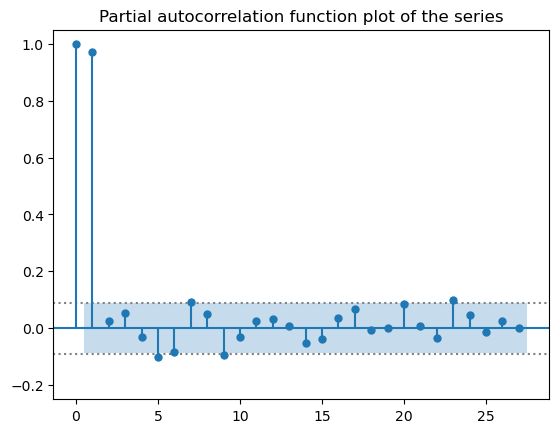

In [14]:
fig, ax = plt.subplots()

n = len(X_raw)
lower_signi_bound = -2 / np.sqrt(n)
upper_signi_bound = 2 / np.sqrt(n)

# Add the horizontal lines showing the significant bounds
ax.axhline(y=lower_signi_bound, linestyle=':', color='gray')
ax.axhline(y=upper_signi_bound, linestyle=':', color='gray')

plot_pacf(X_raw, ax=ax)
plt.title("Partial autocorrelation function plot of the series")
plt.ylim(-0.25, 1.05)

plt.show()

The PACF plot cuts off a lag 1, meaning that an $AR(1)$ process is suitable. 

### Fitting an AR(1) process to the data

In [15]:
arima = ARIMA(X_raw, order=(1, 0, 0))

In [16]:
model = arima.fit()

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  499
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2123.692
Date:                Mon, 10 Apr 2023   AIC                           4253.384
Time:                        17:17:09   BIC                           4266.022
Sample:                             0   HQIC                          4258.344
                                - 499                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1819.4941     33.981     53.544      0.000    1752.892    1886.096
ar.L1          0.9794      0.008    116.426      0.000       0.963       0.996
sigma2       289.3234     13.539     21.370      0.000     262.788     315.859
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                69.37
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.25
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast our results

In [18]:
percent_ci = 0.95

In [19]:
forecast = model.get_forecast(steps=n_test)
ci = forecast.conf_int(alpha=1-percent_ci)

In [20]:
lower_bound = ci[:, 0]
upper_bound = ci[:, 1]

### Plot our results

In [21]:
test_dates = test_data.index

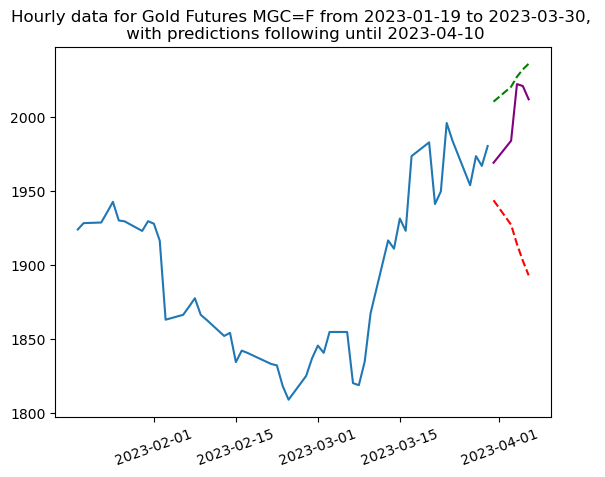

In [22]:
plt.plot(dates[-50:], X_raw[-50:]) # plot of training data
plt.plot(test_dates, test_data["Adj Close"].values, color="purple") # plot of test data
plt.plot(test_dates, lower_bound, linestyle="--", color="red") # plot of lower bound
plt.plot(test_dates, upper_bound, linestyle="--", color="green") # plot of upper bound

plot_start_date = dates[-50:][0].strftime("%Y-%m-%d")

plt.title(f"Hourly data for Gold Futures MGC=F from {plot_start_date} to {train_end_date}, \n with predictions following until {end_date}")
plt.xticks(rotation=20)
plt.show()

## Modelling log-returns

When it comes to stock market data analysis, one of the most common transformations applied to the data is taking the log returns of stock prices rather than using the raw prices themselves. 

Let $P_t$ be the price of a financial security at time $t$. Then, the log return is defined as
$$log \left( \dfrac{P_t}{P_{t-1}}\right) = log(P_t) - log(P_{t-1}).$$

Log returns are more suitable for statistical analysis as they have several desirable properties. These properties make log returns a better choice for statistical modeling and prediction. Furthermore, log returns can be used to measure volatility, which is an important factor in many financial models. 

Let's try to transform our data into log returns: 

In [23]:
X_log_diff = np.diff(np.log(X_raw))

Let's plot our log-returns of the gold futures against time: 

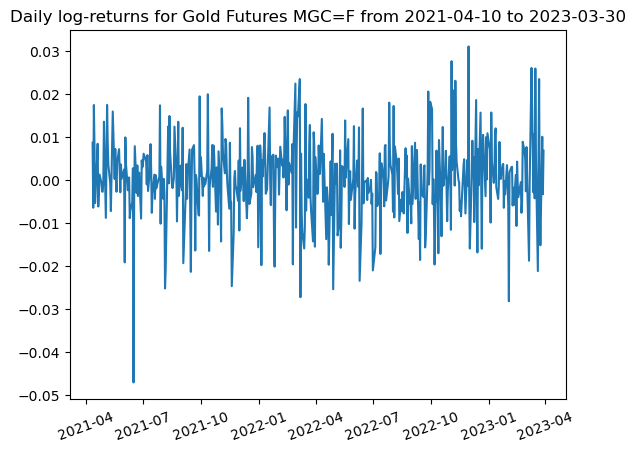

In [24]:
plt.plot(dates[:-1], X_log_diff)
plt.title(f"Daily log-returns for Gold Futures MGC=F from {start_date} to {train_end_date}")
plt.xticks(rotation=20)
plt.show()

Let's try to plot the acf of the log-returns: 

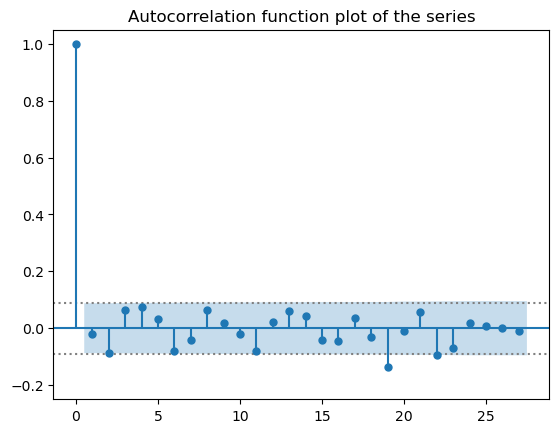

In [25]:
fig, ax = plt.subplots()

n = len(X_log_diff)
lower_signi_bound = -2 / np.sqrt(n)
upper_signi_bound = 2 / np.sqrt(n)

# Add the horizontal lines showing the significant bounds
ax.axhline(y=lower_signi_bound, linestyle=':', color='gray')
ax.axhline(y=upper_signi_bound, linestyle=':', color='gray')

plot_acf(X_log_diff, ax=ax)
plt.title("Autocorrelation function plot of the series")
plt.ylim(-0.25, 1.05)

plt.show()

This acf plot cuts off at subsequent lags, meaning that fitting a white noise process is sufficient. Let's try to fit a white noise process to the log-returns: 

In [26]:
arima_log_returns = ARIMA(X_log_diff, order=(0, 0, 0))

In [27]:
model_log_returns = arima_log_returns.fit()

In [28]:
model_log_returns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  498
Model:                          ARIMA   Log Likelihood                1619.192
Date:                Mon, 10 Apr 2023   AIC                          -3234.384
Time:                        17:17:10   BIC                          -3225.963
Sample:                             0   HQIC                         -3231.079
                                - 498                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.622      0.534      -0.001       0.001
sigma2      8.788e-05   4.11e-06     21.385      0.000    7.98e-05    9.59e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                73.28
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.31
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's try to forecast the futures prices and construct the log-transformed confidence intervals: 

In [29]:
forecast = model_log_returns.get_forecast(steps=n_test)
ci = forecast.conf_int(alpha=1-percent_ci)
ci

array([[-0.01810814,  0.01863803],
       [-0.01810814,  0.01863803],
       [-0.01810814,  0.01863803],
       [-0.01810814,  0.01863803],
       [-0.01810814,  0.01863803]])

In [30]:
lower_bound_returns = np.exp(ci[:, 0])
upper_bound_returns = np.exp(ci[:, 1])
upper_bound

array([2010.32727448, 2020.41087745, 2027.14135567, 2032.12274446,
       2035.98378466])

In [31]:
last_training_price = np.ones(len(lower_bound_returns)) * X_raw[-1]
last_training_price

array([1980.30004883, 1980.30004883, 1980.30004883, 1980.30004883,
       1980.30004883])

In [32]:
lower_bound_price = last_training_price.copy()
for i in range(len(lower_bound_price)):
    lower_bound_price[i] = last_training_price[i] * (lower_bound_returns[:i+1].prod())
lower_bound_price

array([1944.76322893, 1909.86412328, 1875.591288  , 1841.93348456,
       1808.8796761 ])

In [33]:
upper_bound_price = last_training_price.copy()
for i in range(len(upper_bound_price)):
    upper_bound_price[i] = last_training_price[i] * (upper_bound_returns[:i+1].prod())
upper_bound_price

array([2017.5550418 , 2055.51090558, 2094.18082551, 2133.578235  ,
       2173.71682016])

Let's try to plot our predictions with the constructed confidence intervals: 

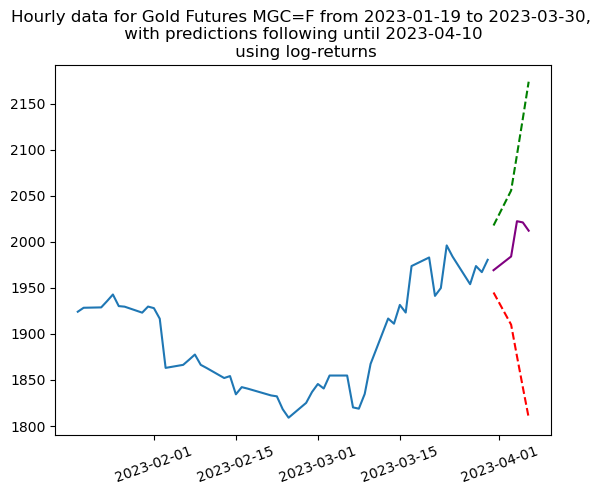

In [34]:
plt.plot(dates[-50:], X_raw[-50:]) # plot of training data
plt.plot(test_dates, test_data["Adj Close"].values, color="purple") # plot of test data
plt.plot(test_dates, lower_bound_price, linestyle="--", color="red") # plot of lower bound
plt.plot(test_dates, upper_bound_price, linestyle="--", color="green") # plot of upper bound

plot_start_date = dates[-50:][0].strftime("%Y-%m-%d")

plt.title(f"Hourly data for Gold Futures MGC=F from {plot_start_date} to {train_end_date}, \n with predictions following until {end_date} \n using log-returns")
plt.xticks(rotation=20)
plt.show()

From the time-series modelling above, we can see that it does not have much predictive power as the constructed confidence intervals is quite wide. Thus, we resort to other predictive frameworks. 

## Deep Learning Frameworks (using LSTM)

Price prediction has long been a challenging task in the field of finance due to its high level of complexity and the presence of various factors that affect stock prices. Deep learning has shown promising results in recent years, especially in the area of stock prediction. Deep learning models are capable of automatically learning and extracting complex patterns and relationships from historical stock data, which can help to make more accurate predictions of future stock prices. By using deep learning techniques, researchers and practitioners are able to address some of the limitations of traditional methods in stock prediction, such as the inability to capture nonlinear relationships and complex dependencies among variables. Additionally, deep learning models can handle large amounts of data and are able to continuously learn and adapt to new market trends, making them a powerful tool in the field of stock prediction. In this demo, we will be focuses a type of recurrent neural network called LSTM. 

LSTM (Long Short-Term Memory) is a type of recurrent neural network that has shown great promise in time series forecasting, including in the field of finance. One of the advantages of LSTM is its ability to capture long-term dependencies in the data, which is particularly useful for modeling complex patterns in financial time series data. LSTM networks have been used for a wide range of financial forecasting tasks, such as stock price prediction, exchange rate forecasting, and portfolio optimization. By leveraging the power of deep learning, LSTM models can potentially outperform traditional time series models and provide more accurate and reliable predictions.

Recall our data before preprocessing (let's get more data for training): 

In [35]:
end_date = datetime.today().strftime("%Y-%m-%d")
start_date = datetime(2010, 10, 4).strftime("%Y-%m-%d")

In [36]:
data = yf.download(ticker, start=start_date, end=end_date)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-04,131.699997,131.710007,131.490005,131.679993,131.679993,65
2010-10-05,134.100006,134.100006,134.100006,134.029999,134.029999,193
2010-10-06,134.100006,135.000000,134.100006,134.770004,134.770004,395
2010-10-19,136.979996,136.979996,132.929993,133.600006,133.600006,533
2010-10-20,133.429993,134.699997,133.380005,134.419998,134.419998,214
...,...,...,...,...,...,...
2023-03-31,1979.699951,1986.300049,1968.199951,1969.000000,1969.000000,235
2023-04-03,1968.199951,1991.500000,1949.400024,1983.900024,1983.900024,222
2023-04-04,1984.199951,2025.099976,1981.000000,2022.199951,2022.199951,89


### Preprocessing

In this demo, we are trying to use the attributes of the previous day to predict the adjusted close price of the next day. Let's preprocess the data and split into training and testing portions. Also, we will scale the data for the output variable $y$.

In [37]:
LAG_DAYS = 22

In [38]:
train_size = 0.8

In [39]:
n = int(len(data) * 0.8)
train_data, test_data = data[:n], data[n-LAG_DAYS:]

In [40]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-10,1946.300049,1966.400024,1940.800049,1956.000000,1956.000000,4221
2020-09-11,1948.300049,1954.699951,1935.599976,1939.500000,1939.500000,2634
2020-09-14,1940.900024,1963.599976,1937.199951,1954.699951,1954.699951,2958
2020-09-15,1957.199951,1973.599976,1947.699951,1958.000000,1958.000000,4322
2020-09-16,1953.400024,1974.800049,1949.699951,1962.000000,1962.000000,4109
...,...,...,...,...,...,...
2023-03-31,1979.699951,1986.300049,1968.199951,1969.000000,1969.000000,235
2023-04-03,1968.199951,1991.500000,1949.400024,1983.900024,1983.900024,222
2023-04-04,1984.199951,2025.099976,1981.000000,2022.199951,2022.199951,89


In [41]:
X_train_raw, X_test_raw = [], []

for i in range(LAG_DAYS, len(train_data)):
    # Reshape X_train into dimensions (n, d, 1)
    X_train_raw.append(train_data.iloc[i-LAG_DAYS:i].values.reshape(-1, 1))

for i in range(LAG_DAYS, len(test_data)):
    X_test_raw.append(test_data.iloc[i-LAG_DAYS:i].values.reshape(-1, 1))

In [42]:
X_train, X_test = np.array(X_train_raw), np.array(X_test_raw)
X_train.shape

(2487, 132, 1)

In [43]:
y_train_unscaled, y_test_unscaled = train_data.iloc[LAG_DAYS:]["Adj Close"].values, test_data.iloc[LAG_DAYS:]["Adj Close"].values
y_train_unscaled.shape

(2487,)

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_train = scaler.fit_transform(y_train_unscaled.reshape(-1, 1))
y_test = scaler.transform(y_test_unscaled.reshape(-1, 1))

In [45]:
assert X_test.shape[0] == y_test.shape[0]

In [46]:
X_test.shape

(628, 132, 1)

In [47]:
y_test.shape

(628, 1)

### Create an LSTM neural network and fit the data

In [48]:
np.random.seed(410)
tf.random.set_seed(410)

In [49]:
MODEL_PATH = f"../models/demo_5_LSTM_lag_{LAG_DAYS}.h5"

In [50]:
trained = False
if os.path.exists(MODEL_PATH):
    trained = True

In [51]:
if not trained:
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(64))
    model.add(Dense(16))
    model.add(Dense(1))
else:
    model = load_model(MODEL_PATH)

2023-04-10 17:17:13.417103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 17:17:13.418647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 17:17:13.422403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 132, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 132, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [53]:
if not trained:
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=16, epochs=16)
    trained = True
    model.save(MODEL_PATH)

Epoch 1/16


2023-04-10 17:17:14.441421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 17:17:14.444695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 17:17:14.448108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

156/156 [==============================] - 60s 349ms/step - loss: 0.0355
Epoch 2/16
156/156 [==============================] - 59s 376ms/step - loss: 0.0108
Epoch 3/16
156/156 [==============================] - 67s 428ms/step - loss: 0.0080
Epoch 4/16
156/156 [==============================] - 63s 407ms/step - loss: 0.0072
Epoch 5/16
156/156 [==============================] - 72s 461ms/step - loss: 0.0051
Epoch 6/16
156/156 [==============================] - 61s 389ms/step - loss: 0.0033
Epoch 7/16
156/156 [==============================] - 51s 325ms/step - loss: 0.0029
Epoch 8/16
156/156 [==============================] - 49s 313ms/step - loss: 0.0022
Epoch 9/16
156/156 [==============================] - 45s 289ms/step - loss: 0.0023
Epoch 10/16
156/156 [==============================] - 48s 308ms/step - loss: 0.0020
Epoch 11/16
156/156 [==============================] - 40s 254ms/step - loss: 0.0018
Epoch 12/16
156/156 [==============================] - 66s 421ms/step - loss: 0.0014


## Predictions

In [54]:
raw_predictions = model.predict(tf.convert_to_tensor(X_test))
predictions = scaler.inverse_transform(raw_predictions)

2023-04-10 17:31:09.927250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 17:31:09.930146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 17:31:09.932641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 4s 128ms/step


Let's plot our results: 

In [55]:
plot_start_date = datetime(2019, 7, 1)
if plot_start_date < datetime.strptime(start_date, "%Y-%m-%d") or plot_start_date is None:
    plot_start_date = datetime.strptime(start_date, "%Y-%m-%d")
plot_start_date = plot_start_date.strftime("%Y-%m-%d")

In [56]:
train_dates, test_dates = train_data.loc[plot_start_date:].index, test_data.index

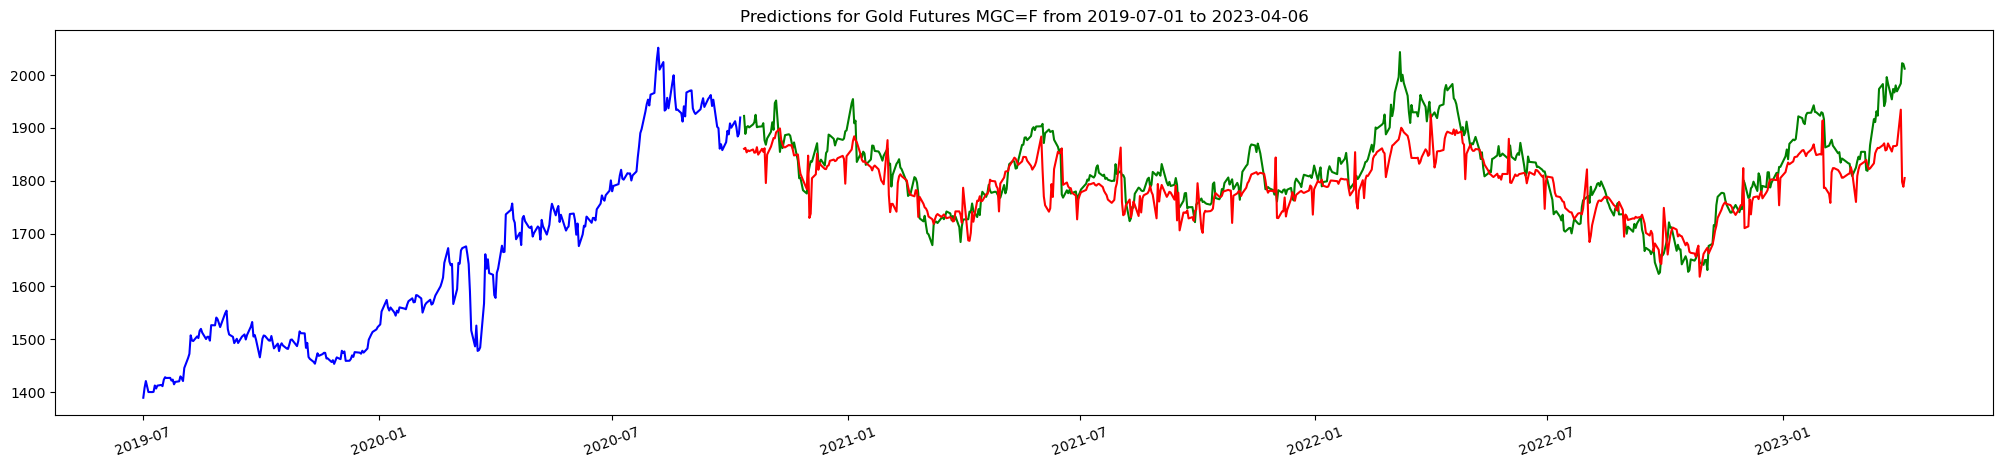

In [57]:
plt.figure(figsize=(25, 5))

plt.plot(train_dates, train_data.loc[plot_start_date:]["Adj Close"].values, color="blue") # plot of train data
plt.plot(test_dates[LAG_DAYS:], test_data[LAG_DAYS:]["Adj Close"].values, color="green") # plot of test data
plt.plot(test_dates[LAG_DAYS:], predictions, color="red") # plot of predictions

plot_start_date = train_dates[0].strftime("%Y-%m-%d")
plot_end_date = test_dates[-1].strftime("%Y-%m-%d")

plt.title(f"Predictions for Gold Futures MGC=F from {plot_start_date} to {plot_end_date}")
plt.xticks(rotation=20)
plt.show()